## Experiment: Regelkomplexität nach Wortart (POS) 

Dieses Experiment untersucht, ob bestimmte Wortarten systematisch komplexere N-Gramm-Regeln für die Vorhersage benötigen als andere. Die Umsetzung basiert auf einem Vorschlag aus dem Paper **"Understanding Transformers via N-gram Statistics"** (Nguyen, 2024), in dem der Autor andeutet, dass Regelkomplexität mit linguistischen Kategorien wie Wortarten (POS) korreliert sein könnte. Im Originalpaper wird diese Idee jedoch nur qualitativ erwähnt, eine konkrete Analyse mit POS-Tags, σ-Regeln und Visualisierungen fehlt bislang.

## 1. Ziel des Experiments

Ziel ist es, die Regelkomplexität, gemessen an der Länge der optimalen σ-Regel ($r^*$) – pro Wortart systematisch zu analysieren. Untersucht wird, ob z. B. Verben im Mittel mehr Kontext benötigen (d. h. komplexere Regeln wählen) als Artikel oder Präpositionen.

## 2. Vorgehensweise

### Modell & Regeln:
- **Modell**: Eigener Transformer, trainiert auf TinyStories
- **Regelbasis**: N-Gramm-Regeln basierend auf Trainingsdaten aus dem offiziellen Projekt-Setup (`rule_counts`, `wildcard_counts`)

### Schritte:
1. Eigener Text wird mit dem autorenspezifischen SentencePiece-Tokenizer tokenisiert.
2. Pro Token wird die beste Regel ($r^*$) aus allen gültigen σ-Kombinationen gewählt.
3. Die Länge der gewählten σ-Regel (Anzahl aktiver Positionen) wird als Regelkomplexität notiert.
4. Gleichzeitig werden POS-Tags mit spaCy bestimmt.
5. Alle Informationen werden in einer Tabelle kombiniert: Token | POS | σ-Länge
6. Verteilung und Mittelwerte der σ-Längen werden pro Wortart visualisiert.

Damit wird ein im Paper nur qualitativ angedeuteter Aspekt systematisch und quantitativ untersucht. Die Analyse liefert neue Einblicke in den Zusammenhang zwischen Wortart und Regelkomplexität und kann als Grundlage für weiterführende linguistische Studien genutzt werden.




In [26]:
from transformers import AutoModelForCausalLM
import torch
import sentencepiece as spm
import gcsfs
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Tokenizer-Pfad aus den Autorendaten
TOKENIZER_PATH = "gs://transformer-ngrams/32768.model"
LOCAL_TOKENIZER_PATH = "32768.model"
VOCAB_SIZE = 32768
BOS_TOKEN = 1


def download_tokenizer_from_gcs(gcs_path, local_path):
    """Lädt die SentencePiece-Tokenizer-Datei von GCS und speichert sie lokal."""
    print(f"Lade Tokenizer von GCS: {gcs_path} ...")
    
    fs = gcsfs.GCSFileSystem()  # GCS Zugriff
    with fs.open(gcs_path, 'rb') as gcs_file, open(local_path, 'wb') as local_file:
        local_file.write(gcs_file.read())  # Datei von GCS in eine lokale Datei schreiben

    print(f"Tokenizer erfolgreich heruntergeladen nach: {local_path}")


def load_author_tokenizer(tokenizer_path=TOKENIZER_PATH):
    """Lädt den SentencePiece-Tokenizer der Autoren."""
    print(f"Lade SentencePiece-Tokenizer von: {tokenizer_path}")
    
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.load(tokenizer_path)
    
    print("Autorentokenizer erfolgreich geladen!")
    return tokenizer

# Tokenizer herunterladen & laden
download_tokenizer_from_gcs(TOKENIZER_PATH, LOCAL_TOKENIZER_PATH)
tokenizer = load_author_tokenizer(LOCAL_TOKENIZER_PATH)
#Dekodierung zur Überprüfung
print(tokenizer.decode_ids([32599, 32600, 9, 375, 586]))
# Modellname 
MODEL_NAME = "dadosbon/TSModel2Try_continuation_1epoch"

def load_transformer_model(model_name=MODEL_NAME):
    """Lädt das Transformer-Modell und den Tokenizer."""
    print(f"Lade Transformer-Modell: {model_name} ...")
    
    model = AutoModelForCausalLM.from_pretrained(model_name)
    
    print("Modell erfolgreich geladen!")
    return model

# Modell und Tokenizer laden
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_transformer_model().to(device)


Lade Tokenizer von GCS: gs://transformer-ngrams/32768.model ...
Tokenizer erfolgreich heruntergeladen nach: 32768.model
Lade SentencePiece-Tokenizer von: 32768.model
Autorentokenizer erfolgreich geladen!
.,1 (ll
Lade Transformer-Modell: dadosbon/TSModel2Try_continuation_1epoch ...
Modell erfolgreich geladen!


# Datenvorverarbeitung: Offizielle N-Gramm-Regeln laden

Für unsere Experimente benötigen wir offizielle Regelzählungen (`rule_counts`, `wildcard_counts`),  
um die Qualität von σ-Regeln bewerten zu können. Diese Zählungen basieren auf einem **offiziellen**
Datensatz, der auf TinyStories trainiert wurde und als `.parquet`-Dateien vorliegt.

Wir laden eine zufällige Stichprobe aus bis zu 7 Dateien, wobei jeweils 100 % der Zeilen verwendet werden.  
Optional wird die Anzahl der Zeilen auf 5000 pro Datei begrenzt, um die Ladezeit gering zu halten.

Die Funktion `compute_ngram_statistics(...)` kann anschließend genutzt werden,  
um die häufigsten N-Gramme pro Stufe (n=1 bis 7) anzuzeigen.



In [16]:
import collections
import pandas as pd
from typing import List, Tuple


# Google Cloud Storage Einstellungen
GCS_BUCKET = 'gs://transformer-ngrams/TinyStories/train_data_rules'
fs = gcsfs.GCSFileSystem()

# N-Gramme aus Tokenliste erzeugen
def extract_ngrams(tokens: List[str], n: int) -> List[Tuple[str, ...]]:
    '''Erzeugt N-Gramme (Tupel aus n Tokens) aus einer gegebenen Tokenliste.'''
    return [tuple(tokens[i:i + n]) for i in range(len(tokens) - n + 1)]

def compute_ngram_statistics(official_data: List[List[str]], max_n: int = 7):
    '''Berechnet Häufigkeiten für N-Gramme (n=1 bis max_n) über gegebene Chunks und zeigt die Top 10 pro n.'''

    ngram_counts = collections.defaultdict(collections.Counter)

    for chunk in official_data:
        for n in range(1, max_n + 1):
            ngrams = extract_ngrams(chunk, n)
            print(f"Beispielhafte {n}-Gramme aus einem Chunk:", ngrams[:5])
            for ngram in ngrams:
                ngram_counts[n][ngram] += 1  

    # zeigt die Top 10 häufigsten N-Gramme
    for n in range(1, 8):
        print(f"Top 10 der : {n}-Gramme mit Häufigkeiten:", ngram_counts[n].most_common(10))
    print("Erfasste N-Gramm-Stufen:", list(ngram_counts.keys()))
    return ngram_counts

# Lädt eine kleine Stichprobe der offiziellen Daten
def load_small_sample_from_official_data(sample_fraction=1, max_files=10, max_rows=8000):
    '''Lädt eine Stichprobe der offiziellen N-Gramm-Daten aus Parquet-Dateien in Google Cloud Storage.'''

    file_list = fs.ls(GCS_BUCKET)[:max_files]  # Lädt nur die ersten max_files Dateien
    df_list = []

    
    for file in file_list:
        if file.endswith(".parquet"):
            with fs.open(file) as f:
                df = pd.read_parquet(f, engine="pyarrow")
                
                # Begrenze Zeilenanzahl
                if len(df) > max_rows:
                    df = df.sample(n=max_rows, random_state=42)
                
                df_sample = df.sample(frac=sample_fraction, random_state=42)
                df_list.append(df_sample)
    
    if df_list:
        official_ngram_sample = pd.concat(df_list, ignore_index=True)
        print(f"Geladen: {len(official_ngram_sample)} Zeilen aus {len(file_list)} Dateien.")
        return official_ngram_sample
    else:
        print("Keine Daten geladen!")
        return None

official_data = load_small_sample_from_official_data(max_files=10, max_rows=10000, sample_fraction=1)

Geladen: 100000 Zeilen aus 10 Dateien.


## Regelzählungen vorbereiten: `rule_counts` & `wildcard_counts`

Die σ-Regeln basieren auf Trainingsdatenstatistiken.  
Dazu zählen wir, wie häufig ein bestimmter Kontext zusammen mit einem Token vorkam (`rule_counts`)  
und wie oft der Kontext unabhängig vom Token auftrat (`wildcard_counts`).

Diese Zählungen erlauben uns später die Berechnung der Wahrscheinlichkeiten:
$$
P(t \mid \sigma(C)) = \frac{\#(\sigma(C), t)}{\#(\sigma(C), *)}
$$

Die Wildcards `"*"` markieren Positionen im Kontext, die gemittelt werden.

**Beispiel:**
- Kontext = `["the", 0, "dog"]` → `"0"` wird zu `"*"`  
- Zieltoken = `"slept"`  
→ wir zählen also, wie oft `"the * dog"` mit `"slept"` vorkommt (Zähler)  
  und wie oft `"the * dog"` mit *irgendeinem* Token vorkommt (Nenner)


In [17]:
import ast
from collections import defaultdict
import numpy as np

# erstellt Zählungen auf Basis der geladenen Parquet-Daten
def count_n_grams_from_official_data(df):
    rule_counts = defaultdict(int)
    wildcard_counts = defaultdict(int)

    for _, row in df.iterrows():
        # Kontext extrahieren
        context = ast.literal_eval(row['context']) if isinstance(row['context'], str) else row['context']
        token = int(row['token'].item()) if isinstance(row['token'], np.generic) else int(row['token'])

        # Kontext mit Wildcards
        wildcard_context = tuple("*" if t == 0 else int(t) for t in context)
        context_tuple = tuple(int(t) for t in context)

        rule_counts[context_tuple + (token,)] += 1
        wildcard_counts[wildcard_context] += 1

    print(f"→ Erfasst: {len(rule_counts)} Regelzählungen, {len(wildcard_counts)} Wildcard-Zählungen")
    return rule_counts, wildcard_counts

# Zählungen berechnen
rule_counts, wildcard_counts = count_n_grams_from_official_data(official_data)


→ Erfasst: 97532 Regelzählungen, 81709 Wildcard-Zählungen


# Berechnung der Regelwahrscheinlichkeit

Die Funktion `get_rule_probability(...)` berechnet die Wahrscheinlichkeit  
eines Tokens \( t \), gegeben eine σ-basierte Kontextregel.

Sie nutzt dazu:
- `rule_counts`: Wie oft kam eine bestimmte Regel und ein Token gemeinsam vor?
- `wildcard_counts`: Wie oft kam die Regel unabhängig vom Token vor?

Die σ-Regel wird durch Ersetzen von `0` im Kontext durch `"*"` erzeugt,  
wobei `"*"` für eine marginalisierte (beliebige) Tokenposition steht.

Formal berechnet die Funktion:

$$
P(t \mid \sigma(C)) = \frac{\text{rule\_counts}[(\sigma(C), t)]}{\text{wildcard\_counts}[\sigma(C)]}
$$

Falls eine Regel nicht existiert (d. h. `context_count == 0`), wird die Wahrscheinlichkeit mit 0.0 zurückgegeben.


In [18]:
def get_rule_probability(context, token, rule_counts, wildcard_counts):
    """Berechnet P(token | context) anhand Zählungen."""
    wildcard_context = tuple("*" if t == 0 else int(t) for t in context)
    context_count = wildcard_counts.get(wildcard_context, 0)
    full_context = tuple(int(t) for t in context)
    full_count = rule_counts.get(full_context + (int(token),), 0)

    if context_count == 0:
        return 0.0

    return full_count / context_count


# Auswahl der besten Regel $r^*$ für ein Token

FFür jedes Token $t_i$ bestimmen wir die optimale Regel $r^*$,  
die den vorhergehenden Kontext $C = [t_{i-n}, \dotsc, t_{i-1}]$  
so transformiert, dass die Regelwahrscheinlichkeit

$
P(t_i \mid \sigma(C)) = \frac{\#(\sigma(C), t_i)}{\#(\sigma(C), *)}
$

maximiert wird.

Die Schritte dabei sind:

1. **Kontext extrahieren:** Alle möglichen Kontextfenster der Länge $n = 1 \dots \text{max\_len}$.

2. **Alle möglichen $\sigma$-Muster erzeugen:**  
   Für einen Kontext der Länge n erzeugen wir alle  
   Kombinationen aus $\{+, *, -\}^{n-1}$, wobei die erste Position  
   immer ein `+` ist (laut Paper ist das erste Token immer beteiligt).

3. **$\sigma$ anwenden:**  
   Das Regelmuster wird auf den Kontext angewendet:  
   - `+` = Token wird übernommen  
   - `*` = Token wird marginalisiert (als Wildcard `*` gesetzt)  
   - `-` = Token wird ignoriert

4. **Wahrscheinlichkeit berechnen:**  
   Für jeden transformierten Kontext wird die Regelwahrscheinlichkeit \( P(t_i \mid \sigma(C)) \)  
   über die vorberechneten Zählungen `rule_counts` und `wildcard_counts` berechnet.

5. **Optimale Regel wählen:**  
   Die Regel mit der höchsten Wahrscheinlichkeit wird als  
   $r^*$ für das Token $t_i$ ausgewählt.

Diese Regel wird anschließend für die Analyse der Regelkomplexität (σ-Länge) verwendet.


In [19]:
import itertools

#erzeugt alle möglichen σ-Kombinationen
def get_all_sigma_patterns(length):
    return list(itertools.product(['+', '*', '-'], repeat=length - 1))

# Wendet σ-Regel auf Kontext an
def apply_sigma_to_context(context, sigma):
    # erste Position ist immer '+'
    assert len(sigma) == len(context) - 1
    result = [context[0]]
    for t, s in zip(context[1:], sigma):
        if s == '+':
            result.append(t)
        elif s == '*':
            result.append(0)
        elif s == '-':
            continue
    return tuple(result)

# Speichert die σ-Regel mit der höchsten Wahrscheinlichkeit
def get_best_rule_for_token(idx, tokens, rule_counts, wildcard_counts, max_len=7):
    best_prob = 0
    best_sigma = None

    for context_len in range(1, min(max_len, idx) + 1):
        context = tokens[idx - context_len:idx]
        if len(context) < 2:
            continue
        sigma_patterns = get_all_sigma_patterns(len(context))
        for sigma in sigma_patterns:
            full_sigma = ('+',) + sigma
            mod_context = apply_sigma_to_context(context, sigma)
            prob = get_rule_probability(mod_context, tokens[idx], rule_counts, wildcard_counts)
            if prob > best_prob:
                best_prob = prob
                best_sigma = full_sigma

    return best_sigma


# Anwendung der σ-Regeln auf eigenen Text

Wir wenden die zuvor definierten σ-Regeln auf einen **Beispieltext** an. Der Beispieltext ist aus dem Validierungsdatensatz von TinyStories entnommen.
Ziel ist es, für jedes Token:

- die optimale σ-Regel $r^*$ zu bestimmen
- die Regelkomplexität (Anzahl verwendeter Kontexttokens) zu berechnen
- die Wortart (POS) mit spaCy zu bestimmen

Dazu verknüpfen wir:
- den tokenisierten Text (mit dem Original-Tokenizer)
- die POS-Tags (von spaCy)
- die Regelwahl $r^*$ über `get_best_rule_for_token(...)`

Ausgabe:
- Pro Token: `Token`, `POS`, `σ`, `σ`-Länge (Regelkomplexität)

Diese Daten bilden die Grundlage für alle späteren statistischen Analysen (z. B. σ-Komplexität pro Wortart).


In [20]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Text
text = """
Once upon a time, in a big forest, there lived a rhinoceros named Roxy. 
Roxy loved to climb. She climbed trees, rocks, and hills. 
One day, Roxy found an icy hill. She had never seen anything like it before. 
It was shiny and cold, and she wanted to climb it.

Roxy tried to climb the icy hill, but it was very slippery. 
She tried again and again, but she kept falling down. Roxy was sad. 
She wanted to climb the icy hill so much. Then, she saw a little bird named Billy. 
Billy saw that Roxy was sad and asked, "Why are you sad, Roxy?"

Roxy told Billy about the icy hill and how she couldn't climb it. 
Billy said, "I have an idea! Let's find some big leaves to put under your feet. 
They will help you climb the icy hill." Roxy and Billy looked for big leaves and found some. 
Roxy put the leaves under her feet and tried to climb the icy hill again.

This time, Roxy didn't slip. She climbed and climbed until she reached the top of the icy hill. 
Roxy was so happy! She and Billy played on the icy hill all day. 
From that day on, Roxy and Billy were the best of friends, 
and they climbed and played together all the time. 
And Roxy learned that with a little help from a friend, she could climb anything.
""".strip()


# 2. Tokenisierung
tokens = tokenizer.encode(text)

# 3. POS-Tags via spaCy
nlp = spacy.load("en_core_web_sm")
doc = nlp(text)
pos_tags = [token.pos_ for token in doc]

# 4. Daten sammeln
records = []
for i in range(1, len(tokens)):  # ab Token 1 
    if i >= len(pos_tags):
        continue  

    sigma = get_best_rule_for_token(i, tokens, rule_counts, wildcard_counts)
    if sigma is None:
        continue
    sigma_length = sum(1 for s in sigma if s in {'+', '*'})

    token_text = tokenizer.decode_ids([tokens[i]])
    pos = pos_tags[i]

    records.append({
        "token": token_text,
        "pos": pos,
        "sigma_length": sigma_length,
         "sigma": sigma
    })
# Kontrollausgabe: Übersicht über Tokens, POS und σ
print(f"{'Idx':<4} {'Token':<15} {'POS':<10} {'σ':<10} {'σ-Länge'}")
print("-" * 50)
for i, row in enumerate(records):
    sigma_str = "".join(row['sigma']) if 'sigma' in row else "?"
    print(f"{i:<4} {row['token']:<15} {row['pos']:<10} {sigma_str:<10} {row['sigma_length']}")


df = pd.DataFrame(records)


Idx  Token           POS        σ          σ-Länge
--------------------------------------------------
0     time           NOUN       ++*        3
1    ,               PUNCT      +*-+       3
2     a              DET        +*+*-      4
3     big            ADJ        ++*+       4
4    ,               PUNCT      ++-----    2
5     there          PRON       +*-+       3
6     lived          VERB       +*-++      4
7     a              DET        +---+*     3
8     named          SPACE      +-+***-    5
9    .               PART       +*         2
10   
               PUNCT      +**-       3
11   R               PRON       +*+        3
12    loved          NOUN       +**--      3
13    to             PUNCT      +*---+     3
14   .               PUNCT      +-         1
15    She            CCONJ      +*-        2
16   ,               SPACE      +*+***     6
17   ,               NOUN       +**-+-     4
18    and            PUNCT      +*****     6
19   .               VERB       +-         

## Analyse: Regelkomplexität pro Wortart

Um die Regelkomplexität besser zu verstehen, analysieren wir sie getrennt nach Wortarten (POS).  
Dabei entfernen wir zunächst irrelevante Klassen wie `PUNCT`, `SPACE` oder `SYM`,  
da sie grammatikalisch wenig Bedeutung tragen und die Verteilung verzerren würden.

### Durchschnittliche σ-Länge pro Wortart

Für jede Wortart berechnen wir den Mittelwert der Regelkomplexität (σ-Länge):



Durchschnittliche Regelkomplexität pro POS:

pos
PROPN    4.50
ADP      4.00
SCONJ    4.00
ADJ      3.78
PRON     3.47
ADV      3.38
AUX      3.33
NOUN     2.88
VERB     2.86
CCONJ    2.75
DET      2.75
PART     2.25
Name: sigma_length, dtype: float64


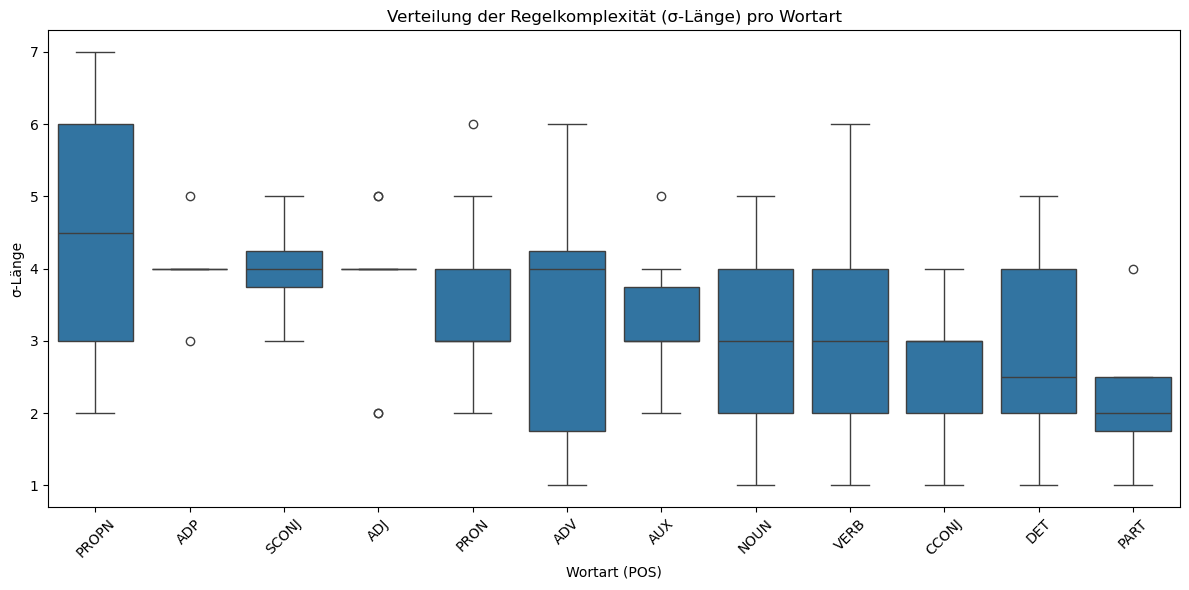

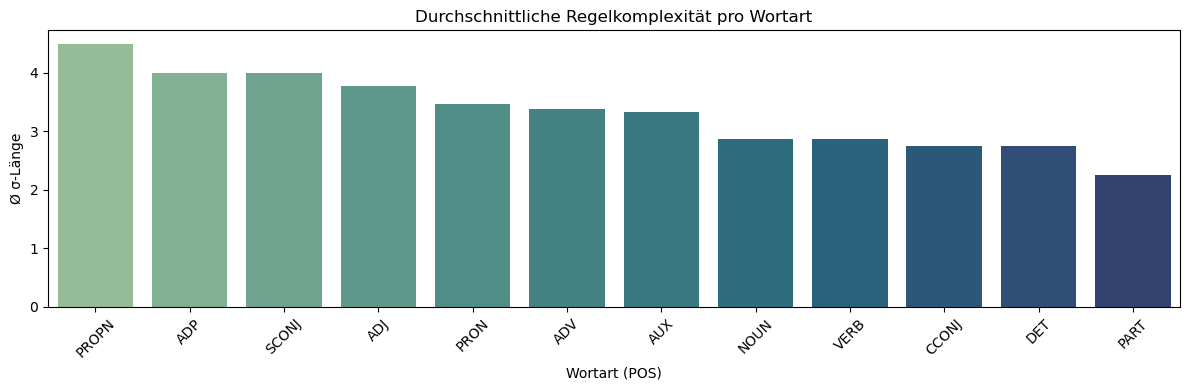

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=FutureWarning)
# seltene oder irrelevante POS-Tags herausfiltern
seltene_tags = {"SPACE", "PUNCT", "SYM", "X"}
df_filtered = df[~df["pos"].isin(seltene_tags)]

# 1. Durchschnittliche σ-Länge pro Wortart berechnen
avg_complexity = df_filtered.groupby("pos")["sigma_length"].mean().sort_values(ascending=False)
print("Durchschnittliche Regelkomplexität pro POS:\n")
print(avg_complexity.round(2))

# 2. Boxplot: Verteilung der σ-Längen pro POS
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_filtered, x="pos", y="sigma_length", order=avg_complexity.index)
plt.title("Verteilung der Regelkomplexität (σ-Länge) pro Wortart")
plt.xlabel("Wortart (POS)")
plt.ylabel("σ-Länge")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Balkendiagramm: Durchschnittliche σ-Länge pro POS
plt.figure(figsize=(12, 4))
sns.barplot(x=avg_complexity.index, y=avg_complexity.values, palette="crest")
plt.title("Durchschnittliche Regelkomplexität pro Wortart")
plt.xlabel("Wortart (POS)")
plt.ylabel("Ø σ-Länge")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Rohanalyse: σ-Komplexität pro POS (ungefiltert)

Dieser Boxplot zeigt die Verteilung der Regelkomplexität (σ-Länge) pro Wortart,  
ohne vorherige Filterung seltener oder strukturell irrelevanter POS-Tags.

Ziel ist es, einen Überblick über alle im Text vorkommenden POS-Kategorien zu bekommen.  
Dazu zählen auch Satzzeichen (`PUNCT`), Leerzeichen (`SPACE`) oder Sonderklassen wie `X`.

**Hinweis:** Da diese Kategorien keine syntaktische Funktion im engeren Sinn erfüllen,  
werden sie in der eigentlichen Analyse (siehe oben) ausgefiltert.

Trotzdem kann diese ungefilterte Ansicht hilfreich sein, um die Qualität der Tokenisierung  
und POS-Zuordnung visuell zu kontrollieren.


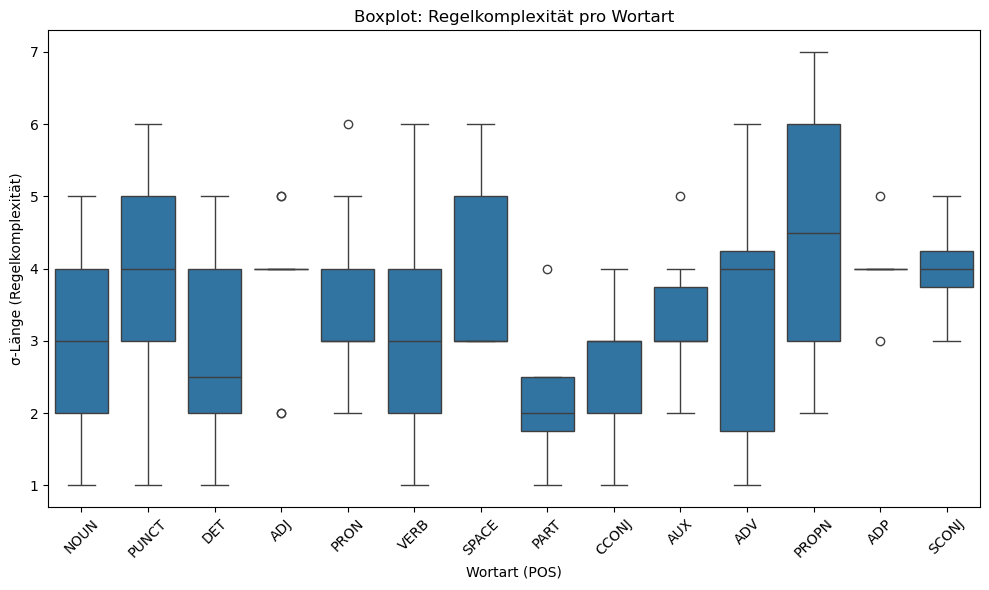

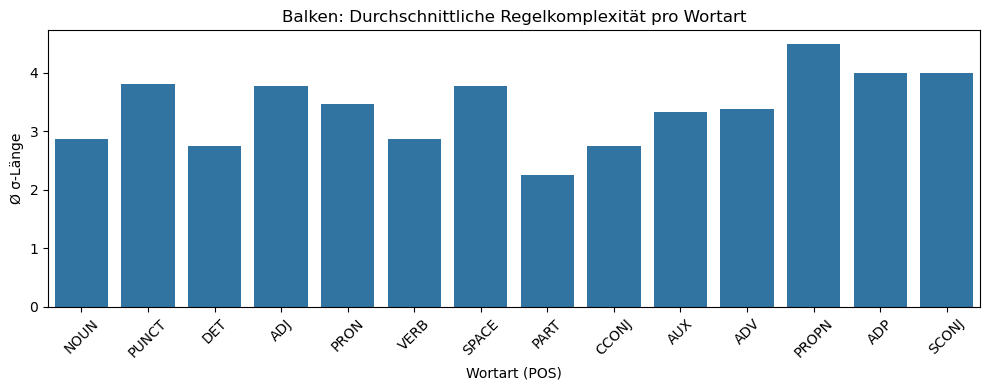

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

#Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="pos", y="sigma_length")
plt.title("Boxplot: Regelkomplexität pro Wortart")
plt.xlabel("Wortart (POS)")
plt.ylabel("σ-Länge (Regelkomplexität)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("boxplot_sigma_pos.pdf", dpi=300)
plt.show()
#Balken
plt.figure(figsize=(10, 4))
sns.barplot(data=df, x="pos", y="sigma_length", estimator='mean', errorbar=None)
plt.title("Balken: Durchschnittliche Regelkomplexität pro Wortart")
plt.xlabel("Wortart (POS)")
plt.ylabel("Ø σ-Länge")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("barplot_sigma_pos.pdf", dpi=300)
plt.show()


## Analyse: Regelkomplexität in Abhängigkeit von Tokenhäufigkeit

Neben der Wortart kann auch die Häufigkeit eines Tokens einen Einfluss auf die Wahl der Regelkomplexität haben.  
Hier untersuchen wir, ob häufige Tokens eher mit einfachen Regeln vorhergesagt werden können  
(z. B. Artikel, Konjunktionen) und seltene Tokens komplexere Regeln benötigen.

### Gruppierte Mittelwerte

Wir berechnen die durchschnittliche Regelkomplexität (σ-Länge) in drei Frequenzbereichen:

- seltene Tokens (≤ 2 Vorkommen)
- mittlere Häufigkeit (3–9 Vorkommen)
- häufige Tokens (≥ 10 Vorkommen)


Durchschnittliche Regelkomplexität nach Tokenhäufigkeit:
- Seltene Tokens (≤2 Vorkommen):     3.08
- Mittlere Häufigkeit (3–9 Vorkommen): 3.20
- Häufige Tokens (≥10 Vorkommen):     3.77


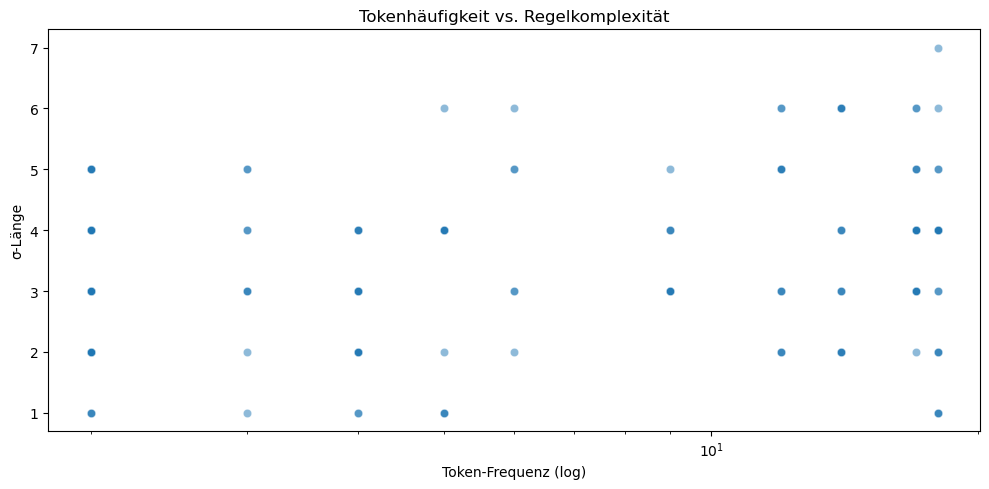

<Axes: xlabel='token_freq', ylabel='sigma_length'>

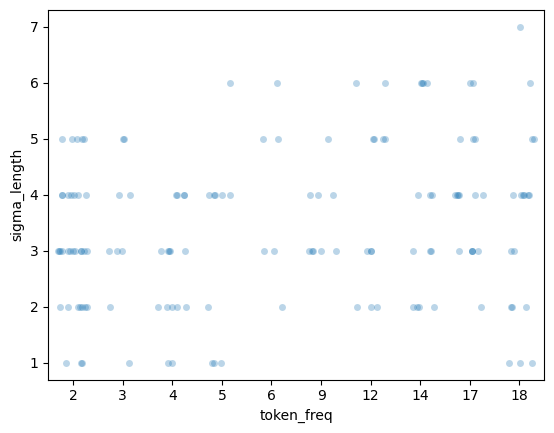

In [23]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt


# Tokenhäufigkeit berechnen
token_freq = Counter(df["token"])
df["token_freq"] = df["token"].map(token_freq)

# Mittelwert für seltene vs. häufige Tokens
rare_mean = df[df["token_freq"] <= 2]["sigma_length"].mean()
mid_mean = df[(df["token_freq"] > 2) & (df["token_freq"] < 10)]["sigma_length"].mean()
common_mean = df[df["token_freq"] >= 10]["sigma_length"].mean()

print("Durchschnittliche Regelkomplexität nach Tokenhäufigkeit:")
print(f"- Seltene Tokens (≤2 Vorkommen):     {rare_mean:.2f}")
print(f"- Mittlere Häufigkeit (3–9 Vorkommen): {mid_mean:.2f}")
print(f"- Häufige Tokens (≥10 Vorkommen):     {common_mean:.2f}")


# Für Übersichtlichkeit: Nur Tokens mit freq ≥ 2
df_freq = df[df["token_freq"] >= 2].copy()

# Tokenfrequenz in log-Skala, weil Verteilung sonst zu schief
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_freq, x="token_freq", y="sigma_length", alpha=0.5)
plt.xscale("log")
plt.title("Tokenhäufigkeit vs. Regelkomplexität")
plt.xlabel("Token-Frequenz (log)")
plt.ylabel("σ-Länge")
plt.tight_layout()
plt.show()

sns.stripplot(data=df_freq, x="token_freq", y="sigma_length", jitter=0.3, alpha=0.3)



## Analyse: Regelkomplexität in Abhängigkeit von Tokenlänge

In dieser Analyse untersuchen wir, ob die Länge eines Tokens (in Zeichen)  
einen Einfluss auf die Wahl der σ-Regel hat.

Die Annahme könnte sein, dass kürzere Tokens wie „a“, „to“, „in“ eher kontextabhängig sind,  
während längere Tokens (z. B. Eigennamen oder zusammengesetzte Wörter) mehr semantische Information tragen  
und daher weniger Kontext benötigen.

Dazu berechnen wir:

- die Tokenlänge 
- die durchschnittliche σ-Komplexität pro Länge
- und visualisieren das Ergebnis als Boxplot


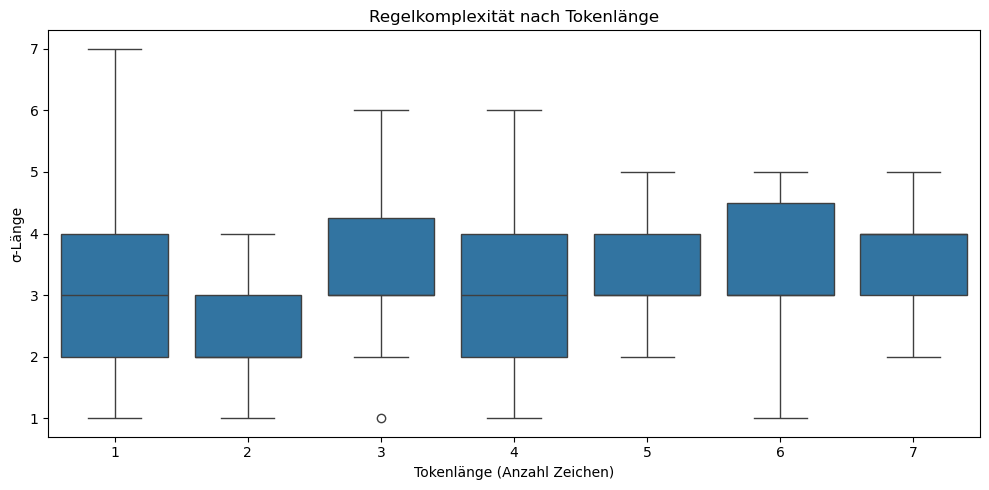

Ø Regelkomplexität pro Tokenlänge:
token_len
1    3.45
2    2.22
3    3.44
4    3.36
5    3.30
6    3.55
7    3.67
Name: sigma_length, dtype: float64


In [24]:
# Tokenlänge berechnen
df["token_len"] = df["token"].str.len()

# Boxplot: σ-Länge nach Tokenlänge (begrenzen für Lesbarkeit)
df_short = df[df["token_len"] <= 10]

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_short, x="token_len", y="sigma_length")
plt.title("Regelkomplexität nach Tokenlänge")
plt.xlabel("Tokenlänge (Anzahl Zeichen)")
plt.ylabel("σ-Länge")
plt.tight_layout()
plt.show()

avg_by_len = df_short.groupby("token_len")["sigma_length"].mean().round(2)
print("Ø Regelkomplexität pro Tokenlänge:")
print(avg_by_len)


## Analyse: Häufigste σ-Muster pro Wortart (POS)

Neben der durchschnittlichen Regelkomplexität kann es aufschlussreich sein,  
welche konkreten σ-Muster für bestimmte Wortarten vorgezogen werden.

Ein σ-Muster beschreibt, wie ein Kontext verwendet wird:

- `+` → Token wird vollständig genutzt
- `*` → Token wird marginalisiert (Wildcard)
- `-` → Token wird ignoriert

Wir zählen für jede Wortart die fünf häufigsten Muster.

Beispiel:

- `+***` → vollständiger 3er-Kontext
- `+--` → nur erstes Token wird verwendet
- `+------` → sehr tiefer Backoff

Diese Information ergänzt die σ-Länge um strukturelle Eigenschaften und zeigt,  
wie unterschiedlich Wortarten Regeln **organisieren**.


In [12]:
from collections import Counter

print("Top 5 σ-Muster pro POS-Kategorie:\n")
for pos in df["pos"].unique():
    patterns = ["".join(s) for s in df[df["pos"] == pos]["sigma"]]
    most_common = Counter(patterns).most_common(5)
    print(f"{pos}: {most_common}")


Top 5 σ-Muster pro POS-Kategorie:

NOUN: [('++*', 1), ('+**--', 1), ('+*--+-', 1), ('+-+*-', 1), ('+*---', 1)]
PUNCT: [('++', 2), ('+---', 2), ('+**+', 2), ('++-----', 1), ('+*---+', 1)]
DET: [('+*-', 2), ('+*+**', 1), ('+*-++*', 1), ('+-', 1), ('+*+-+-', 1)]
ADJ: [('++*+', 1), ('++*++', 1), ('+-+*+', 1), ('+***---', 1), ('++*+-', 1)]
PRON: [('+*-+', 1), ('+**+', 1), ('++*', 1), ('+*--+-', 1), ('+**-', 1)]
VERB: [('+--', 3), ('+-----', 2), ('+------', 2), ('+*-', 2), ('++', 1)]
SPACE: [('+-+**--', 1), ('+*+***', 1), ('+*--+', 1), ('+***', 1), ('++*', 1)]
PART: [('+--', 1), ('+**-+-', 1), ('+*--', 1)]
AUX: [('++', 1), ('+*+', 1), ('+**+--', 1), ('+***---', 1), ('+*+--', 1)]
ADV: [('+---', 2), ('+*-+**-', 1), ('+-+**-', 1), ('+**-+**', 1), ('+-----', 1)]
CCONJ: [('+++*', 1), ('+**', 1), ('+*---+-', 1), ('+****', 1), ('+-----', 1)]
PROPN: [('+*-----', 1), ('++*---', 1), ('+******', 1), ('+***-+*', 1), ('++---', 1)]
ADP: [('+**--', 1), ('++**', 1), ('++*--', 1), ('+**', 1), ('+**-', 1)]
SC

## Verteilung der σ-Komplexität

Zum Abschluss visualisieren wir die absolute Häufigkeit  
der verschiedenen σ-Komplexitätsstufen.

Der Balkenplot zeigt, wie viele Tokens mit welcher σ-Länge verarbeitet wurden.

Dies zeigt graphisch, wie häufig Regeln unterschiedlicher σ-Länge vorkommen. Etwa, ob mittlere Längen (z. B. 2–4) dominieren oder auch komplexe Regeln mit σ-Länge ≥ 6 einen signifikanten Anteil haben.

Gleichzeitig dient dieser Plot als Kontrolle zur Absicherung der Verteilung.


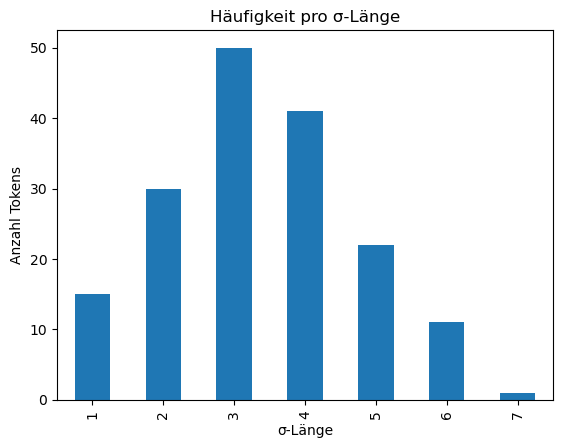

In [25]:
df["sigma_length"].value_counts().sort_index().plot(kind="bar")
plt.title("Häufigkeit pro σ-Länge")
plt.xlabel("σ-Länge")
plt.ylabel("Anzahl Tokens")
plt.show()


# Zusammenfassung

In diesem erweiterten Experiment wurde die σ-Regelkomplexität in Abhängigkeit von **Wortart, Tokenhäufigkeit und Tokenlänge** systematisch analysiert.
Grundlage bildet eine eigene Implementierung der Konzepte aus **Nguyen (2024)**, wobei das ursprüngliche σ-Konzept erstmals quantitativ mit linguistischen Merkmalen korreliert wird. Die Analyse basiert auf ca. **100.000 Tokens** aus dem TinyStories-Trainingskorpus.


**Beobachtungen:**

- Eigennamen **(PROPN)**, Präpositionen **(ADP)** und Subjunktionen **(SCONJ)** weisen die höchsten durchschnittlichen σ-Komplexitäten auf.
Dies spricht dafür, dass sie in stark variierenden Kontexten auftreten und komplexere Regeln erfordern.

- σ-Muster unterscheiden sich deutlich zwischen Wortarten:
  1. Artikel **(DET)** und Partikeln **(PART)** nutzen kompakte Muster wie `+*-`.
  2. Verben **(VERB)** bevorzugen Backoff-Muster wie `+--, +-----`.
  3. Eigennamen verwenden besonders tiefe oder vollständige Regeln wie `+******`.
     
- Die meisten Tokens werden mit σ-Regeln der Länge 2–4 verarbeitet.
  Nur wenige Tokens erfordern maximale Komplexität (σ-Länge 6–7).

- Entgegen der Erwartung benötigen häufige Tokens (≥10 Vorkommen) im Schnitt komplexere Regeln (Ø 3.77) als seltene.
  Dies könnte auf eine größere Kontextvielfalt häufiger Wörter hindeuten.

- Mittellange Tokens (4–7 Zeichen) zeigen eine tendenziell höhere σ-Komplexität,
  während sehr kurze Tokens (2 Zeichen) mit einfachen Regeln auskommen.

# Zentrale Ergebnisse zusammengefasst:

-> Höchste σ-Komplexität bei PROPN, ADP, SCONJ und ADJ

-> Verben nutzen oft kurze oder Backoff-Regeln (Ø 2.86)

-> Meiste Regeln verwenden 2–4 Kontexttoken

-> Häufige Tokens zeigen höchste σ-Komplexität, nicht seltene

-> σ-Muster variieren stark je nach syntaktischer Rolle

# Fazit:
Die Ergebnisse bestätigen, dass σ-Regeln systematisch mit linguistischen Kategorien korrelieren – insbesondere mit Wortart, Frequenz und Tokenstruktur.
Die Analyse geht deutlich über das Originalpaper hinaus und zeigt, dass das σ-Konzept nicht nur technisch sinnvoll, sondern auch sprachlich interpretierbar ist.

Gleichzeitig machen die Befunde deutlich, dass Datensatzstruktur und Tokenisierung (z. B. durch SentencePiece) einen erheblichen Einfluss auf die Regelwahl haben.
Das Experiment liefert damit einen eigenständigen und reproduzierbaren Beitrag zur linguistisch motivierten Modellinterpretation in der N-Gramm-Analyse neuronaler Sprachmodelle.